In [1]:
import pandas as pd
import numpy as np

In [2]:

pd.set_option("display.max_colwidth", None)       # allow wrapping
pd.set_option("display.expand_frame_repr", False) # no horizontal sliding

df = pd.read_csv("Davis.txt", sep=r"\s+", header=None)

df.columns = [
    "Compound_ID",
    "Protein_ID",
    "Compound_SMILES",
    "Protein_Sequence",
    "Binding_Affinity_pKd",
    "Protein_SecondaryStructure"
]
pd.set_option('display.max_colwidth', 50)
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 10)

print(df.head(11))
print("\nShape:", df.shape)

df.to_csv("Davis.csv", index=False)


    Compound_ID    Protein_ID                                    Compound_SMILES                                   Protein_Sequence  Binding_Affinity_pKd                         Protein_SecondaryStructure
0      11314340          AAK1  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...  MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQV...              7.366532  CCCCCCHHHHCCCCCCCCCCCCCCCCHHCHHHHHHHHHHCCCCCCC...
1      11314340   ABL1(E255K)  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...  PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...              5.000000  CCHHHHCHHHHCCCEEEEECCCCCCECCCCCCCCCCCEEEEECCCC...
2      11314340   ABL1(F317I)  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...  PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...              5.000000  CCHHHHCHHHHCCCEEEEECCCCCCECCCCCCCCCCCEEEEECCCC...
3      11314340  ABL1(F317I)p  CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...  PFWKILNPLLERGTYYYFMGQQPGKVLGDQRRPSLPALHFIKGAGK...              5.000000  CCHHHHCHHHHCCCEEEEECCCCCC

In [3]:
# preprocess.py
!pip install rdkit
import os,sys
from rdkit import Chem
import pickle
from tqdm import tqdm

IN_FILE = "Davis.csv"   # or Davis.csv
OUT_CSV = "Davis_clean.csv"
GRAPH_CACHE = "smiles_graphs.pkl"

def read_input(path):
    if path.lower().endswith(".txt"):
        # multi-space separated
        df = pd.read_csv(path, sep=r"\s+", header=None, engine="python")
    else:
        df = pd.read_csv(path)
    # Expect 6 columns
    if df.shape[1] != 6:
        raise ValueError(f"Expected 6 columns but got {df.shape[1]}")
    df.columns = ["DrugID","ProteinID","SMILES","ProteinSeq","pKd","SecStruct"]
    return df

# Simple sanitize: drop rows with missing
def clean_df(df):
    df = df.dropna().reset_index(drop=True)
    # Ensure pKd numeric
    df["pKd"] = pd.to_numeric(df["pKd"], errors="coerce")
    df = df.dropna(subset=["pKd"]).reset_index(drop=True)
    return df

# Build RDKit Mol and simple canonical SMILES
def mol_from_smiles(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return None
        Chem.Kekulize(mol, clearAromaticFlags=True) if mol.GetNumBonds()>0 else None
        return mol
    except:
        return None

# Graph feature builder (small)
def smiles_to_graph_data(smi):
    mol = mol_from_smiles(smi)
    if mol is None:
        return None
    atoms = []
    for a in mol.GetAtoms():
        atoms.append(atom_features(a))
    edges = []
    edge_index = [[],[]]
    edge_attr = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index[0].append(i); edge_index[1].append(j)
        edge_index[0].append(j); edge_index[1].append(i)
        # bond features
        bf = bond_features(bond)
        edge_attr.append(bf); edge_attr.append(bf)
    return {"n_atoms": len(atoms),"atom_feats": atoms, "edge_index": edge_index, "edge_attr": edge_attr}

# small atom/bond features - tweakable
def atom_features(a):
    return [
        a.GetAtomicNum(),
        a.GetTotalNumHs(),
        int(a.GetIsAromatic()),
        a.GetDegree(),
        a.GetFormalCharge()
    ]

def bond_features(b):
    bt = b.GetBondType()
    return [
        float(bt == Chem.rdchem.BondType.SINGLE),
        float(bt == Chem.rdchem.BondType.DOUBLE),
        float(bt == Chem.rdchem.BondType.TRIPLE),
        float(bt == Chem.rdchem.BondType.AROMATIC)
    ]

def build_graph_cache(df, outpath=GRAPH_CACHE):
    cache = {}
    for smi in tqdm(df["SMILES"].unique(), desc="Building graph cache"):
        g = smiles_to_graph_data(smi)
        cache[smi] = g
    with open(outpath, "wb") as f:
        pickle.dump(cache, f)
    print("Saved graph cache to", outpath)
    return cache

if __name__ == "__main__":
    df = read_input(IN_FILE)
    df = clean_df(df)
    print("Rows after clean:", len(df))
    df.to_csv(OUT_CSV, index=False)
    print("Saved cleaned CSV:", OUT_CSV)
    # build graph cache
    cache = build_graph_cache(df)


Rows after clean: 30056
Saved cleaned CSV: Davis_clean.csv


Building graph cache: 100%|██████████| 68/68 [00:00<00:00, 829.93it/s]

Saved graph cache to smiles_graphs.pkl


In [4]:
# dataset cell (must be run BEFORE train cell)
import os, torch, pickle
import pandas as pd
from rdkit import Chem
from torch.utils.data import Dataset
from torch_geometric.data import Data

AA_LIST = list("ACDEFGHIKLMNPQRSTVWY")
AA2IDX = {a:i+1 for i,a in enumerate(AA_LIST)}

def seq_to_indices(s, max_len=1000):
    idx = [AA2IDX.get(c,0) for c in s]
    if len(idx) > max_len: idx = idx[:max_len]
    return idx

def load_graph_cache(p):
    if os.path.exists(p):
        with open(p,"rb") as f:
            return pickle.load(f)
    return {}

class DavisDataset(Dataset):
    def __init__(self, csv_path, graph_cache_path="smiles_graphs.pkl", max_protein_len=1000):
        self.df = pd.read_csv(csv_path)  # pd must be imported
        self.max_protein_len = max_protein_len
        self.graph_cache = load_graph_cache(graph_cache_path)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        smi = row["SMILES"]
        prot = row["ProteinSeq"]
        y = float(row["pKd"])

        g = self.graph_cache.get(smi)
        if g is None:
            x = torch.zeros((1,5), dtype=torch.float)
            ei = torch.zeros((2,0), dtype=torch.long)
            ea = torch.zeros((0,4), dtype=torch.float)
        else:
            x = torch.tensor(g["atom_feats"], dtype=torch.float)
            ei = torch.tensor(g["edge_index"], dtype=torch.long)
            ea = torch.tensor(g["edge_attr"], dtype=torch.float)

        p_idx = seq_to_indices(prot, self.max_protein_len)
        p_idx = torch.tensor(p_idx, dtype=torch.long)
        y = torch.tensor([y], dtype=torch.float)

        d = Data(x=x, edge_index=ei, edge_attr=ea, y=y)
        d.protein = p_idx
        return d


In [5]:
#writefile model.py
!pip install torch
!pip install torch_geometric
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool

class GINEncoder(nn.Module):
    def __init__(self, in_dim=5, hidden=128, n_layers=3):
        super().__init__()
        self.convs = nn.ModuleList()
        self.batch = nn.ModuleList()
        for i in range(n_layers):
            in_ch = in_dim if i == 0 else hidden
            nn1 = nn.Sequential(nn.Linear(in_ch, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            self.convs.append(GINConv(nn1))
            self.batch.append(nn.BatchNorm1d(hidden))
    def forward(self, x, edge_index, batch):
        for conv, bn in zip(self.convs, self.batch):
            x = F.relu(bn(conv(x, edge_index)))
        return global_add_pool(x, batch)

class ProteinCNN(nn.Module):
    def __init__(self, vocab=21, embed=128, channels=128):
        super().__init__()
        self.embed = nn.Embedding(vocab, embed, padding_idx=0)
        self.conv = nn.Conv1d(embed, channels, 5, padding=2)
        self.pool = nn.AdaptiveMaxPool1d(1)
    def forward(self, seq):
        x = self.embed(seq).permute(0,2,1)
        x = F.relu(self.conv(x))
        return self.pool(x).squeeze(-1)

class GraphDTAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gnn = GINEncoder()
        self.cnn = ProteinCNN()
        self.fc = nn.Sequential(
            nn.Linear(128 + 128, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    def forward(self, batch):
        g = self.gnn(batch.x, batch.edge_index, batch.batch)
        p = self.cnn(batch.protein)
        return self.fc(torch.cat([g,p], dim=1)).squeeze(1)


In [6]:
#writefile utils.py
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

def rmse(y, p):
    return np.sqrt(mean_squared_error(y, p))

def pearson(y, p):
    return pearsonr(y, p)[0]

def concordance_index(y_true, y_pred):
    n = 0 ; s = 0
    for i in range(len(y_true)):
        for j in range(i+1, len(y_true)):
            if y_true[i] == y_true[j]: continue
            n += 1
            if (y_true[i] < y_true[j] and y_pred[i] < y_pred[j]) or \
               (y_true[i] > y_true[j] and y_pred[i] > y_pred[j]):
                s += 1
            elif y_pred[i] == y_pred[j]:
                s += 0.5
    return s / n


In [7]:
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphDTAModel().to(device)


model = torch.compile(model)
model = GraphDTAModel().to(device)


CUDA available: False
Device: CPU


In [8]:
# train.py
import os
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from sklearn.model_selection import train_test_split
from tqdm import tqdm

SEED = 42
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def collate_fn(batch):
    max_len = max([d.protein.shape[0] for d in batch])
    prot_padded = []
    for d in batch:
        p = d.protein
        if p.shape[0] < max_len:
            pad = torch.zeros(max_len - p.shape[0], dtype=torch.long)
            p = torch.cat([p, pad], dim=0)
        prot_padded.append(p.unsqueeze(0))
    prot_padded = torch.cat(prot_padded, dim=0)
    batch_g = Batch.from_data_list(batch)
    batch_g.protein = prot_padded
    return batch_g

def train_epoch(model, loader, opt, device):
    model.train()
    losses = []
    for batch in tqdm(loader, desc="train"):
        batch = batch.to(device)
        opt.zero_grad()
        y = batch.y.view(-1).to(device)
        preds = model(batch)
        loss = torch.nn.functional.mse_loss(preds, y)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ys=[]; ps=[]
    for batch in tqdm(loader, desc="eval"):
        batch = batch.to(device)
        y = batch.y.view(-1).cpu().numpy()
        p = model(batch).cpu().numpy()
        ys.append(y); ps.append(p)
    ys=np.concatenate(ys); ps=np.concatenate(ps)
    return ys, ps

def main(args):
    seed_everything()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Use DavisDataset class already defined in notebook
    ds = DavisDataset(args.csv, graph_cache_path=args.graph_cache, max_protein_len=args.max_protein_len)

    idxs = list(range(len(ds)))
    train_idx, test_idx = train_test_split(idxs, test_size=args.test_size, random_state=SEED)
    train_idx, val_idx = train_test_split(train_idx, test_size=args.val_size, random_state=SEED)

    train_ds = torch.utils.data.Subset(ds, train_idx)
    val_ds = torch.utils.data.Subset(ds, val_idx)
    test_ds = torch.utils.data.Subset(ds, test_idx)

    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, collate_fn=collate_fn)

    # Use GraphDTAModel already defined in notebook
    model = GraphDTAModel().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-5)

    best_val_rmse = 1e9
    os.makedirs(args.out_dir, exist_ok=True)

    for epoch in range(1, args.epochs+1):
        train_loss = train_epoch(model, train_loader, opt, device)
        ys_val, ps_val = evaluate(model, val_loader, device)
        val_rmse = rmse(ys_val, ps_val)
        val_pear = pearson(ys_val, ps_val)
        val_ci = concordance_index(ys_val, ps_val)
        print(f"Epoch {epoch} | train_loss {train_loss:.4f} | val_rmse {val_rmse:.4f} | pearson {val_pear:.4f} | CI {val_ci:.4f}")
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            torch.save(model.state_dict(), os.path.join(args.out_dir, "best_model.pt"))

    # final test
    model.load_state_dict(torch.load(os.path.join(args.out_dir, "best_model.pt")))
    ys_test, ps_test = evaluate(model, test_loader, device)
    print("Test RMSE:", rmse(ys_test, ps_test))
    print("Test Pearson:", pearson(ys_test, ps_test))
    print("Test CI:", concordance_index(ys_test, ps_test))

    import pandas as pd
    df = pd.read_csv(args.csv)
    test_rows = df.iloc[test_idx].copy().reset_index(drop=True)
    test_rows["pred_pKd"] = ps_test
    test_rows.to_csv(os.path.join(args.out_dir, "predictions_test.csv"), index=False)
    print("Saved test predictions to", os.path.join(args.out_dir, "predictions_test.csv"))

if __name__ == "__main__":
    class Args:
        csv = "Davis_clean.csv"
        graph_cache = "smiles_graphs.pkl"
        out_dir = "outputs"
        batch_size = 32
        epochs = 3
        lr = 1e-3
        test_size = 0.2
        val_size = 0.1
        max_protein_len = 1000

    args = Args()
    main(args)


eval: 100%|██████████| 76/76 [00:09<00:00,  7.77it/s]


Epoch 1 | train_loss 0.8822 | val_rmse 0.8148 | pearson 0.4585 | CI 0.7271


eval: 100%|██████████| 76/76 [00:09<00:00,  7.99it/s]


Epoch 2 | train_loss 0.6538 | val_rmse 0.8067 | pearson 0.4990 | CI 0.7480


eval: 100%|██████████| 76/76 [00:09<00:00,  8.18it/s]


Epoch 3 | train_loss 0.6083 | val_rmse 0.7870 | pearson 0.5237 | CI 0.7624


eval: 100%|██████████| 188/188 [00:23<00:00,  8.12it/s]


Test RMSE: 0.7340708569489038
Test Pearson: 0.56707335
Test CI: 0.7862316174515684
Saved test predictions to outputs\predictions_test.csv


In [9]:
import pandas as pd
df = pd.read_csv("outputs/predictions_test.csv")
print(df.columns)

Index(['DrugID', 'ProteinID', 'SMILES', 'ProteinSeq', 'pKd', 'SecStruct',
       'pred_pKd'],
      dtype='object')


In [10]:
y_true = df["pKd"].values


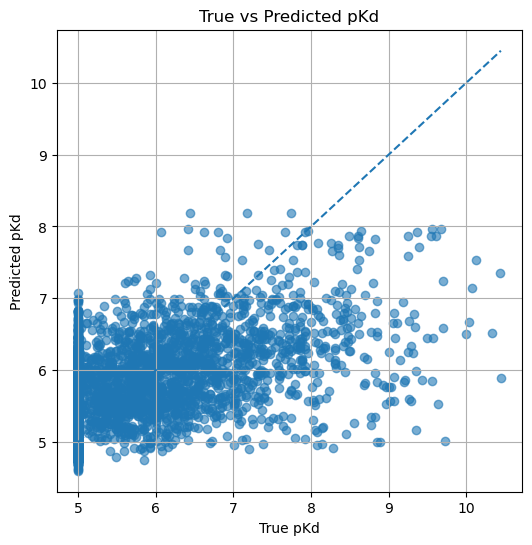

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

# Load predictions
df = pd.read_csv("outputs/predictions_test.csv")

# Ground-truth and predictions
y_true = df["pKd"].values
y_pred = df["pred_pKd"].values

# ------------ PLOT 1: Scatter (True vs Predicted) ------------
plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], "--")  # diagonal line
plt.xlabel("True pKd")
plt.ylabel("Predicted pKd")
plt.title("True vs Predicted pKd")
plt.grid(True)
plt.show()


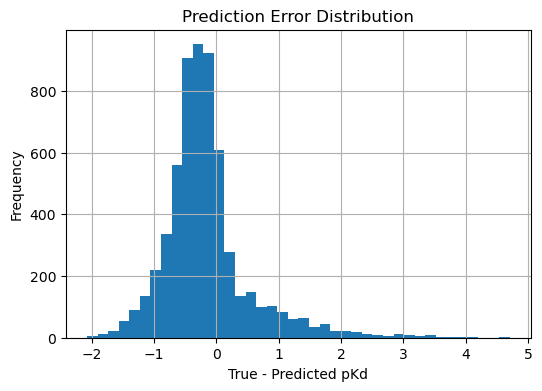

RMSE: 0.7340708501705153
Pearson: 0.5670733393276576
R^2: 0.28680678017732875


In [12]:
# ------------ PLOT 2: Error Distribution ------------
errors = y_true - y_pred
plt.figure(figsize=(6,4))
plt.hist(errors, bins=40)
plt.title("Prediction Error Distribution")
plt.xlabel("True - Predicted pKd")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# ------------ METRICS ------------
rmse = np.sqrt(np.mean((y_true - y_pred)**2))
pear = pearsonr(y_true, y_pred)[0]
r2 = r2_score(y_true, y_pred)

print("RMSE:", rmse)
print("Pearson:", pear)
print("R^2:", r2)